# Sequential Decision Making Game

In this paper, we explore a novel approach for decision-making in a discretized spatial domain characterized by a Gaussian Process (GP)-generated value distribution. Our focus is on an automated agent tasked with the optimization of profit within this domain, which is structured as an $N \times N$ grid, encompassing $N^2$ potential locations. Each location within this gridded domain is associated with a distinct value, predetermined by a Gaussian Process. This process is governed by a known kernel function, primarily influenced by the spatial distance between points in the grid.

The primary challenge addressed in this study lies in the agent's initial state of knowledge. While the agent is equipped with the underlying generative function for the grid values, it lacks information regarding the specific realization of these values. Therefore, the agent's strategic exploration and selection of grid locations are crucial to its success. The overarching objective of the agent is to maximize profit, defined as the cumulative value of the selected grid locations.

The methodology employed in this work leverages a neural network as a value function, designed to guide the agent's decision-making process. The input to this neural network comprises three distinct channels: (1) a binary map indicating previously selected locations, (2) a map representing the mean expected values across the grid, and (3) a variance map reflecting the uncertainty in these expected values. Notably, the variance is nullified at locations that have been selected, depicting a state of complete information post-selection.

The neural network's output is bifurcated into two channels. The first channel predicts the expected total reward (ER) by the conclusion of the agent's operation, based on its current policy. The second channel quantifies the variance associated with this expected reward, thus providing a measure of uncertainty and risk inherent in the agent's policy.

In [3]:
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from numpy.linalg import cholesky, LinAlgError
import matplotlib.pyplot as plt

No valid moves left with a mean value >= 0.
Game finished.


Text(0.5, 1.0, 'Variance Values of Non-Selected Locations')

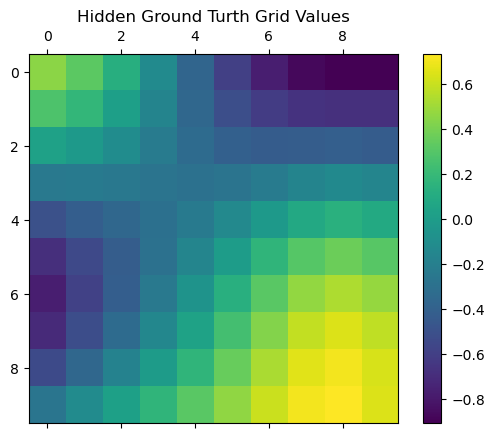

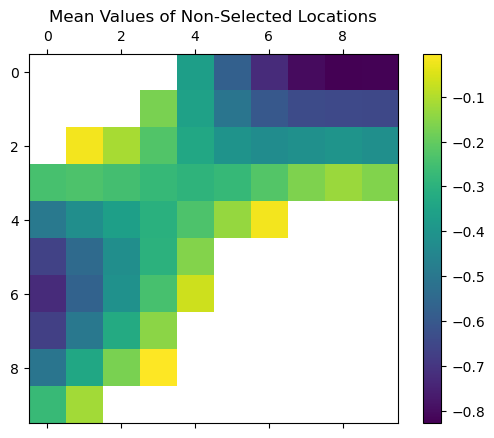

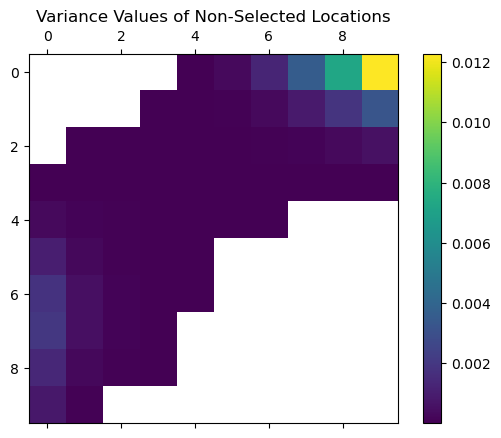

In [4]:
class Game:
    def __init__(self, N, strategy='greedy'):
        self.N = N
        self.strategy = strategy
        self.length_scale = 5
        self.grid_values = self.generate_gp_values()
        self.sequence = [np.random.randint(0, N, size=2).tolist()]
        self.observation = [self.grid_values[self.sequence[-1][0], self.sequence[-1][1]]]
        location_list = [self.sequence[-1]]
        value_list = self.observation
        self.current_mean, self.current_variance = self.calculate_mean_variance(location_list, value_list, self.length_scale)
        self.selected_map = np.zeros((N, N))
        self.selected_map[self.sequence[-1][0], self.sequence[-1][1]] = 1

    def generate_gp_values(self, mean_shift=0.3):
        x = np.linspace(0, self.N-1, self.N)
        y = np.linspace(0, self.N-1, self.N)
        X, Y = np.meshgrid(x, y)
        xy = np.vstack([X.ravel(), Y.ravel()]).T

        gp = GaussianProcessRegressor(kernel=RBF(self.length_scale))
        values = gp.sample_y(xy, random_state=42) + mean_shift
        return values.reshape(self.N, self.N)


    def rbf_kernel(self, X1, X2, length_scale):
        """Compute the RBF kernel between two sets of points."""
        dists = cdist(X1, X2, 'sqeuclidean')
        return np.exp(-0.5 * dists / length_scale**2)

    def calculate_mean_variance(self, location_list, value_list, length_scale):
        x, y = np.meshgrid(range(self.N), range(self.N))
        full_grid = np.vstack([x.ravel(), y.ravel()]).T

        # Convert location_list to a set of tuples for efficient searching
        location_set = set(map(tuple, location_list))

        known_points = np.array(location_list)
        known_values = np.array(value_list)
        unknown_points = np.array([p for p in full_grid if tuple(p) not in location_set])

        # Build kernel matrices
        K = self.rbf_kernel(known_points, known_points, length_scale)
        K_star = self.rbf_kernel(unknown_points, known_points, length_scale)
        K_star_star = self.rbf_kernel(unknown_points, unknown_points, length_scale)

        # Regularization term for numerical stability
        reg_term = 1e-6 * np.eye(K.shape[0])

        try:
            # Cholesky decomposition for numerical stability
            L = cholesky(K + reg_term)
            L_inv = np.linalg.inv(L)
            K_inv = L_inv.T @ L_inv
        except LinAlgError:
            raise RuntimeError("Failed to invert kernel matrix. The problem might be ill-conditioned.")

        # Compute the conditional mean and variance
        conditional_mean = K_star @ K_inv @ known_values
        conditional_variance = K_star_star - K_star @ K_inv @ K_star.T

        # Ensure variances are non-negative (due to numerical issues)
        conditional_variance = np.maximum(conditional_variance, 0)

        # Map back to grid
        mean_map = np.full((self.N, self.N), np.nan)
        variance_map = np.full((self.N, self.N), np.nan)
        mean_map[unknown_points[:, 0], unknown_points[:, 1]] = conditional_mean
        variance_map[unknown_points[:, 0], unknown_points[:, 1]] = np.diag(conditional_variance)
        return mean_map, variance_map
    
    def make_decision(self):
        """
        Selects the next action based on the specified strategy.

        Parameters:
        strategy (str): The decision-making strategy to use ('greedy' or 'curious').

        Returns:
        tuple or None: The coordinates of the selected action, or None if no valid move is available.
        """
        # Find unselected locations
        unselected_locations = np.where(self.selected_map == 0)

        if self.strategy == 'greedy':
            # Extract mean values for these locations
            values = self.current_mean[unselected_locations]
        elif self.strategy == 'curious':
            # Calculate mean + 1 standard deviation for these locations
            std_deviation = np.sqrt(self.current_variance[unselected_locations])
            values = self.current_mean[unselected_locations] + std_deviation
        else:
            raise ValueError("Unknown strategy: choose 'greedy' or 'curious'")

        # Check if there are any values >= 0
        if np.any(values >= 0):
            # Find the location with the highest value among those >= 0
            max_index = np.argmax(values)
            action = (unselected_locations[0][max_index], unselected_locations[1][max_index])
            return action
        else:
            # No valid moves available
            return None

    def play_move(self, action):
        """
        Play a move given an action.

        Parameters:
        action (tuple or list): The location on the grid to play the move.

        Returns:
        bool: True if the move was played successfully, False otherwise.
        """
        # Check if the action is within the grid bounds
        if (0 <= action[0] < self.N) and (0 <= action[1] < self.N):
            # Check if the location has not been selected yet
            if self.selected_map[action[0], action[1]] == 0:
                # Perform the action: update the selected map, observation, sequence, and possibly the mean/variance maps
                self.selected_map[action[0], action[1]] = 1
                self.observation.append(self.grid_values[action[0], action[1]])
                self.sequence.append(action)
                self.current_mean, self.current_variance = self.calculate_mean_variance(self.sequence, self.observation, self.length_scale)

                return True
            else:
                print("This location has already been selected. Choose another location.")
                return False
        else:
            print("Invalid action. The location is outside the grid bounds.")
            return False

    def play(self):
        """
        Plays the game by repeatedly making decisions and executing moves.
        The game ends when all locations are selected or no beneficial moves are left.
        """
        while not np.all(self.selected_map):
            action = self.make_decision()
            
            if action is None:
                print("No valid moves left with a mean value >= 0.")
                break

            move_successful = self.play_move(action)
            if not move_successful:
                print("Failed to play the move:", action)
                break

            # Additional logic (if any) after each move

        print("Game finished.")

    def plot_rbf_kernel(self, fixed_point=None, num_points=100):
        """
        Plots the RBF kernel values for a range of distances.

        Parameters:
        fixed_point (array-like): A fixed point to compare against. Defaults to the origin.
        num_points (int): Number of points to generate for plotting.
        """
        if fixed_point is None:
            fixed_point = np.zeros((1, 2))  # Default to the origin

        # Generate a range of points along one axis (for simplicity)
        x = np.linspace(-10, 10, num_points).reshape(-1, 1)
        y = np.zeros_like(x)
        points = np.hstack([x, y])

        # Compute the RBF kernel values
        kernel_values = self.rbf_kernel(fixed_point, points, self.length_scale)

        # Plot
        plt.figure(figsize=(8, 4))
        plt.plot(x, kernel_values[0], label=f'Length scale = {self.length_scale}')
        plt.xlabel('Distance from fixed point')
        plt.ylabel('Kernel value')
        plt.title('RBF Kernel Visualization')
        plt.legend()
        plt.show()

game = Game(10, strategy='curious')
game.play()


# Where do you play next?

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(game.grid_values, interpolation='nearest')
fig.colorbar(cax)
plt.title('Hidden Ground Turth Grid Values')

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(game.current_mean, interpolation='nearest')
fig.colorbar(cax)
plt.title('Mean Values of Non-Selected Locations')

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(game.current_variance, interpolation='nearest')
fig.colorbar(cax)
plt.title('Variance Values of Non-Selected Locations')

## Simulation Overview: Comparing Greedy and Curious Strategies in the Game

In this simulation, we aim to compare two distinct strategies – "Greedy" and "Curious" – in the context of our grid-based game, which is governed by Gaussian Process (GP) generated values. 

### Game Description
- The game is played on an \( N \times N \) grid.
- Each cell in the grid has a value that is unknown to the player initially.
- The values in the grid are generated based on a Gaussian Process with a Radial Basis Function (RBF) kernel.

### Strategies
1. **Greedy Strategy**: This approach involves selecting the cell with the highest expected value (mean) that hasn't been selected yet. The aim is to maximize immediate reward.

2. **Curious Strategy**: In contrast, this method selects the cell based on the highest value of "mean + 1 standard deviation". This strategy seeks to balance exploration (selecting cells with higher uncertainty) and exploitation (selecting cells with higher expected values).

### Simulation Process
- We will run multiple instances of the game for both strategies.
- For each game instance, we will track:
  - The distribution of the actual mean values of the grid.
  - The cumulative reward obtained during the game.
- These metrics will be used to evaluate and compare the effectiveness of each strategy.

### Objectives
- **Comparative Analysis**: Understand how each strategy performs in terms of exploration and exploitation.
- **Decision-making Insights**: Gain insights into the decision-making process under uncertainty.
- **Strategy Evaluation**: Assess which strategy potentially leads to higher cumulative rewards and a more effective exploration of the grid.

### Expected Outcomes
- By analyzing the distributions of game means and cumulative rewards, we expect to observe the inherent trade-offs between the Greedy and Curious strategies.
- This simulation should highlight the advantages and potential drawbacks of each strategy in different scenarios within the game.

In [5]:
def run_simulation(strategy, N, num_games):
    game_means = []
    cumulative_rewards = []

    for _ in range(num_games):
        game = Game(N, strategy)
        total_reward = 0
        game.play()
        game_means.append(np.mean(game.grid_values))
        cumulative_rewards.append(np.sum(game.observation))

    return game_means, cumulative_rewards

# Parameters
N = 10  # Grid size
num_games = 100  # Number of games to simulate for each strategy

# Run simulations
greedy_means, greedy_rewards = run_simulation('greedy', N, num_games)
curious_means, curious_rewards = run_simulation('curious', N, num_games)

print('The mean of the greedy strategy is', np.mean(greedy_rewards), 'and the mean of the curious strategy is', np.mean(curious_rewards))

No valid moves left with a mean value >= 0.
Game finished.
No valid moves left with a mean value >= 0.
Game finished.
No valid moves left with a mean value >= 0.
Game finished.
No valid moves left with a mean value >= 0.
Game finished.
No valid moves left with a mean value >= 0.
Game finished.
No valid moves left with a mean value >= 0.
Game finished.
No valid moves left with a mean value >= 0.
Game finished.
No valid moves left with a mean value >= 0.
Game finished.
No valid moves left with a mean value >= 0.
Game finished.
No valid moves left with a mean value >= 0.
Game finished.
No valid moves left with a mean value >= 0.
Game finished.
No valid moves left with a mean value >= 0.
Game finished.
No valid moves left with a mean value >= 0.
Game finished.
No valid moves left with a mean value >= 0.
Game finished.
No valid moves left with a mean value >= 0.
Game finished.
No valid moves left with a mean value >= 0.
Game finished.
No valid moves left with a mean value >= 0.
Game finishe

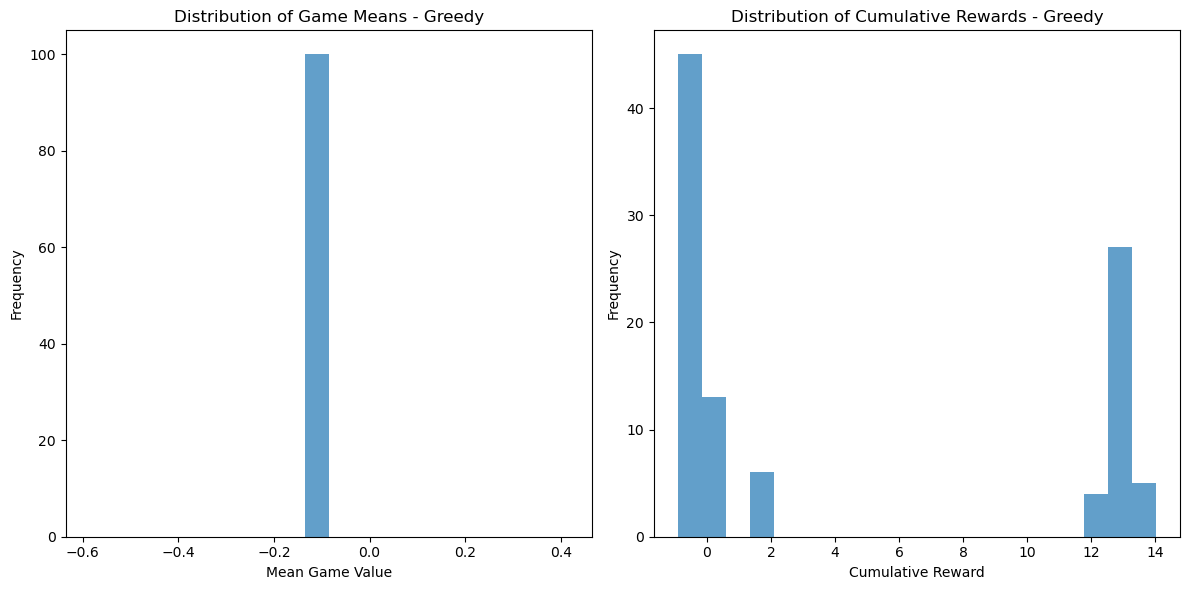

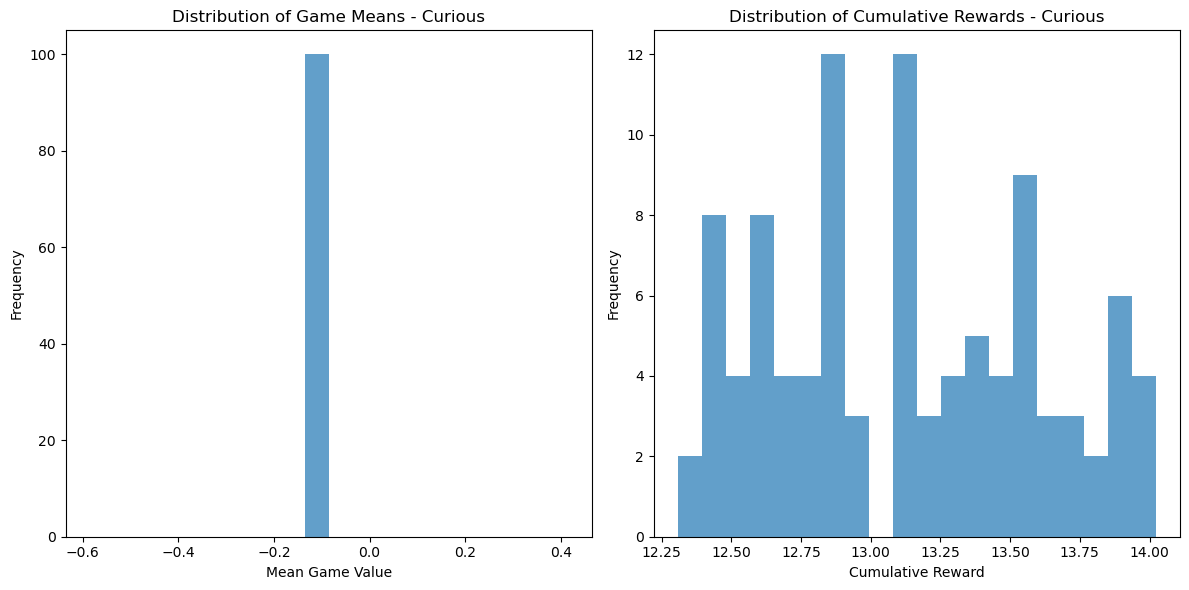

In [6]:
def plot_results(strategy_means, strategy_rewards, strategy_name):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot distribution of game means
    axes[0].hist(strategy_means, bins=20, alpha=0.7, label=strategy_name)
    axes[0].set_title(f'Distribution of Game Means - {strategy_name}')
    axes[0].set_xlabel('Mean Game Value')
    axes[0].set_ylabel('Frequency')

    # Plot distribution of cumulative rewards
    axes[1].hist(strategy_rewards, bins=20, alpha=0.7, label=strategy_name)
    axes[1].set_title(f'Distribution of Cumulative Rewards - {strategy_name}')
    axes[1].set_xlabel('Cumulative Reward')
    axes[1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()


# Plot results for each strategy
plot_results(greedy_means, greedy_rewards, 'Greedy')
plot_results(curious_means, curious_rewards, 'Curious')


## Interactive Gaussian Process Game

Welcome to the interactive Gaussian Process (GP) Grid Game! This game provides a hands-on experience in decision-making using Gaussian Processes on a grid. You'll explore different strategies to maximize your rewards in a grid-based environment where each cell's value is unknown until it's selected.

### Game Setup

- **Grid Size**: The game is played on an \( N \times N \) grid.
- **Initial Setup**: Each cell in the grid has a value determined by a Gaussian Process, which is initially unknown to the player.
- **Strategies**: You can choose between two strategies:
  - **Greedy**: Maximizes immediate reward by selecting the cell with the highest expected value.
  - **Curious**: Balances exploration and exploitation by selecting the cell with the highest value of "mean + 1 standard deviation".

### How to Play

- **Making Moves**: You will be prompted to enter x and y coordinates to select a cell on the grid.
- **Rewards**: After each move, you'll see:
  - The reward from your last selection.
  - Your cumulative reward.
- **Visual Feedback**: A plot will display the values of the cells you have selected so far.
- **Exiting the Game**: Enter 'X' at any point if you wish to exit the game before completing it.

Enjoy the experience of uncovering the mysteries of the Gaussian Process grid, and let's see how much reward you can accumulate!


Current Cumulative Reward: 0


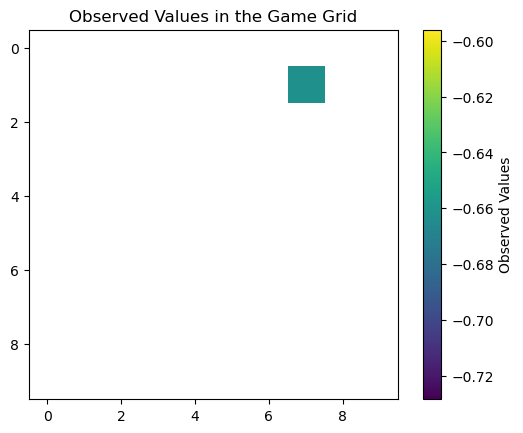

Exiting the game. Final cumulative reward: 0
Game Over! Your final cumulative reward is: 0


In [7]:
def plot_observed_values(game):
    observed_grid = np.full((game.N, game.N), np.nan)  # Initialize with NaNs
    for (x, y) in game.sequence:
        observed_grid[x, y] = game.grid_values[x, y]  # Fill in observed values

    plt.imshow(observed_grid, cmap='viridis')
    plt.colorbar(label='Observed Values')
    plt.title('Observed Values in the Game Grid')
    plt.show()

def play_interactive_game(N, strategy='greedy'):
    game = Game(N, strategy)
    cumulative_reward = 0

    while not np.all(game.selected_map):
        print("\nCurrent Cumulative Reward:", cumulative_reward)
        plot_observed_values(game)

        # Get user input for next move
        x_input = input(f"Enter the x-coordinate for your next move (0 to {N-1}), or 'X' to exit: ")
        if x_input.upper() == 'X':
            print("Exiting the game. Final cumulative reward:", cumulative_reward)
            break

        try:
            x = int(x_input)
            y = int(input(f"Enter the y-coordinate for your next move (0 to {N-1}): "))
        except ValueError:
            print("Invalid input. Please enter integer coordinates or 'X' to exit.")
            continue

        if not (0 <= x < N and 0 <= y < N):
            print("Coordinates out of bounds. Please try again.")
            continue

        if game.selected_map[x, y] == 1:
            print("You have already selected this location. Please try another.")
            continue

        success = game.play_move((x, y))
        if success:
            last_reward = game.grid_values[x, y]
            cumulative_reward += last_reward
            print(f"Reward from last selection: {last_reward}")
        else:
            print("Move failed. Try again.")

    print("Game Over! Your final cumulative reward is:", cumulative_reward)

# Start the game
play_interactive_game(N=10, strategy='greedy')

